In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import os
import pathlib
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')

In [4]:
tf.config.set_visible_devices(
    physical_devices[1], 'GPU'
)

# Data Loading

In [5]:
path_train = 'CINIC10/train/'
path_valid = 'CINIC10/valid/'
path_test = 'CINIC10/test/'
data_dir_train = pathlib.Path(path_train)
data_dir_val = pathlib.Path(path_valid)
data_dir_test = pathlib.Path(path_test)

In [6]:
list_ds_train = tf.data.Dataset.list_files(str(data_dir_train/'*/*'))
list_ds_val = tf.data.Dataset.list_files(str(data_dir_val/'*/*'))
list_ds_test = tf.data.Dataset.list_files(str(data_dir_test/'*/*'))

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir_train.glob('*')])

In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [9]:
def decode_img(img,dsize):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [dsize[0], dsize[1]])

In [10]:
def process_path(file_path):
    size = (224,224)
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img,size )
    return img, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
labeled_ds_train = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_valid = list_ds_val.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
def normalize(x, y):
    x = tf.image.per_image_standardization(x)
    return x, y

In [14]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000, batch_size = 128):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.map(normalize)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [15]:
train_ds = prepare_for_training(labeled_ds_train, batch_size=128)
val_ds = prepare_for_training(labeled_ds_valid, batch_size=128)
test_ds = prepare_for_training(labeled_ds_test, batch_size=128)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# MobileNet Details

Contrary to training large models we use less regularization and data augmentation techniques because small models have less trouble with overfitting. When training MobileNets we do not use side heads or label smoothing and additionally reduce the amount image of distortions by limiting the size of small
crops that are used in large Inception training.
Additionally, they found that it was important to put very little or no weight decay (l2 regularization) on the depthwise filters since there are so few parameters in them.

40 epochs --> lr 0.01

10 epochs --> lr 0.001

10 epochs --> lr 0.0001

# Model Definition

In [17]:
class Model:
    def __init__(self, n_classes):
        self.n_classes = n_classes
        
    def initial_block(self, inputs, width_multiplier = 1):
        x = tf.keras.layers.Conv2D(round(32*width_multiplier),kernel_size=3, strides=2, padding='same')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.nn.relu(x)
        return x
    
    def deph_sep_conv(self, x, n_channels , downsample = False, width_multiplier = 1):
        n_channels = round(n_channels * width_multiplier)
        stride = 2 if downsample else 1
        
        x = tf.keras.layers.SeparableConv2D(n_channels, kernel_size = 3, strides = stride, padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.nn.relu(x)
        
        return x 
    
    def final_block(self, x):
        x = tf.keras.layers.AveragePooling2D(pool_size=7)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(1024)(x)
        x = tf.keras.layers.Dense(self.n_classes, activation='softmax')(x)
        return x
    
    def build_model(self):
        inputs = tf.keras.layers.Input(shape=(224,224,3))
        x = self.initial_block(inputs)
        x = self.deph_sep_conv (x, 64)
        x = self.deph_sep_conv (x, 64, downsample = True)
        x = self.deph_sep_conv (x, 128)
        x = self.deph_sep_conv (x, 128, downsample = True)
        x = self.deph_sep_conv (x, 256)
        x = self.deph_sep_conv (x, 256, downsample = True)
        for i in range (5):
            x = self.deph_sep_conv (x, 512)
        x = self.deph_sep_conv (x, 512, downsample = True)
        x = self.deph_sep_conv (x, 1024)
        x = self.final_block(x)
        model = tf.keras.Model(inputs, x)
        return model

In [18]:
model = Model(10)

In [19]:
model = model.build_model()

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
tf_op_layer_Relu (TensorFlow [(None, 112, 112, 32)]    0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 112, 112, 64)      2400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
tf_op_layer_Relu_1 (TensorFl [(None, 112, 112, 64)]    0     

# Training

In [22]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [23]:
history = model.fit(train_ds,
                    epochs = 40,
                    steps_per_epoch = 100,
                    verbose = 1,
                    validation_data = val_ds,
                    validation_steps = 100)

Train for 100 steps, validate for 100 steps
Epoch 1/40
100/100 [==============================] - 113s 1s/step - loss: 2.0821 - accuracy: 0.2301 - val_loss: 2.3029 - val_accuracy: 0.1027
Epoch 2/40
100/100 [==============================] - 88s 876ms/step - loss: 1.8381 - accuracy: 0.3070 - val_loss: 2.3046 - val_accuracy: 0.1035
Epoch 3/40
100/100 [==============================] - 81s 813ms/step - loss: 1.7235 - accuracy: 0.3548 - val_loss: 2.3110 - val_accuracy: 0.0962
Epoch 4/40
100/100 [==============================] - 80s 800ms/step - loss: 1.6425 - accuracy: 0.3883 - val_loss: 2.3267 - val_accuracy: 0.0999
Epoch 5/40
100/100 [==============================] - 71s 706ms/step - loss: 1.6049 - accuracy: 0.3992 - val_loss: 2.3776 - val_accuracy: 0.1016
Epoch 6/40
100/100 [==============================] - 78s 783ms/step - loss: 1.5640 - accuracy: 0.4172 - val_loss: 2.5161 - val_accuracy: 0.0995
Epoch 7/40
100/100 [==============================] - 43s 430ms/step - loss: 1.5265 - ac

# Evaluation

In [24]:
loss_test, accuracy_test = model.evaluate(test_ds,
                                        verbose = 1,
                                        steps = 5)

5/5 [==============================] - 6s 1s/step - loss: 1.2869 - accuracy: 0.5453


In [25]:
loss_test, accuracy_test

(1.2868710994720458, 0.5453125)

# Training results visualization

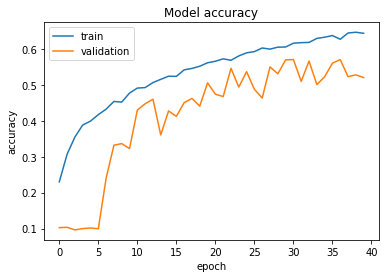

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

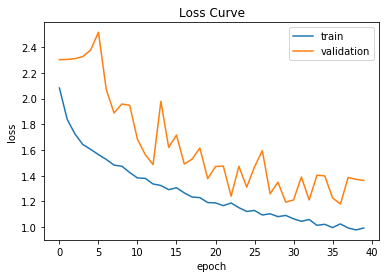

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()